In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

In [2]:
#### Data Visualization here

data_normal = pd.read_csv('dataset/ecg_dataset/ptbdb_normal.csv', header = None)
data_abnormal = pd.read_csv('dataset/ecg_dataset/ptbdb_abnormal.csv', header = None)
classes_names = {0 : "normal",
                 1 : "abnormal"}

num_cols = data_normal.shape[1] - 1
time = np.arange(0, num_cols) / 125
time = time * 1000
data_normal.columns = list(time) + ["label"]
data_abnormal.columns = list(time) + ["label"]
df_ptbd = pd.concat([data_normal, data_abnormal], axis = 0)
counts = df_ptbd["label"].value_counts()
counts.index = counts.index.map(classes_names)

In [4]:
#### Data concatenation and preparation here
normal_df = pd.read_csv("dataset/ecg_dataset/ptbdb_normal.csv", header=None)
abnormal_df = pd.read_csv("dataset/ecg_dataset/ptbdb_abnormal.csv", header=None)

originalAbnormalSize = len(abnormal_df) # for the plots

abnormal_df.rename(columns={'187': "Label"}, inplace=True)
normal_df.rename(columns={'187': "Label"}, inplace=True)

#downsample the abnormal df to a size closer to the normal df
abnormal_df = abnormal_df.sample(n=5000, random_state=1)
total_df = pd.concat([normal_df, abnormal_df])

len(total_df)

# abnormal_df
# normal_df

9046

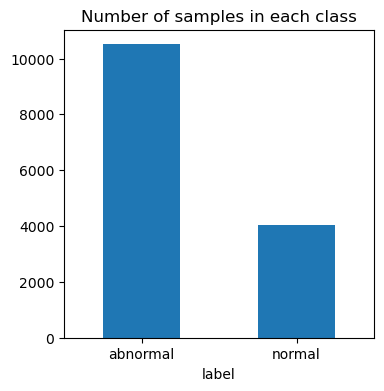

In [5]:
# create a figure
plt.figure(figsize = (4, 4))
# plot a bar chart
counts.plot(kind = "bar")
# plot xticks in angle
plt.xticks(rotation = 0)
plt.title("Number of samples in each class")
plt.show()
# plt.savefig('T1NumSamples.png', bbox_inches='tight')
plt.close()

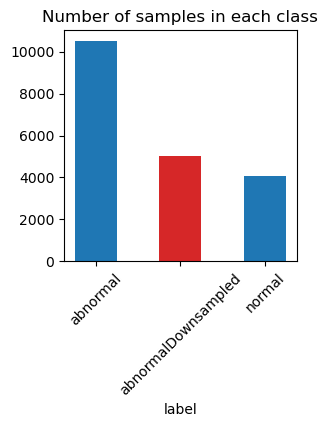

In [7]:
names = ['abnormal', 'abnormalDownsampled', 'normal']
scores = [originalAbnormalSize, 5000, len(normal_df)]

fig, ax = plt.subplots(figsize = (3,3))

plt.xticks(rotation=45)
bar_labels = ['red', 'blue', 'yellow', 'orange']
bar_colors = ['tab:blue', 'tab:red', 'tab:blue']

ax.bar(names, scores, color=bar_colors, width=0.5)
# ax.barh(names, scores, color=bar_colors)

ax.set_xlabel('label')
ax.set_title('Number of samples in each class')

plt.show()
# plt.savefig('T1Downsampled.png', bbox_inches='tight')
plt.close()

## Train test split

In [19]:
#### Model init and training here
X, y = total_df.iloc[:,:187], total_df.iloc[:,-1:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators = 150, min_samples_split=5, random_state=1, bootstrap=False)
# random forest has worse confusion matrix
# model = XGBClassifier(use_label_encoder=True, eval_metric="logloss", n_estimators=700, learning_rate=0.1, random_state=1)
# xgb has much better confusion matrix overall but false negative is still not that low
# model = AdaBoostClassifier(n_estimators=100, algorithm="SAMME", random_state=1)
# logistic regression has 

model.fit(X_train, y_train)
print("Current model accuracy Score:", cross_val_score(model, X, y).mean())
y_pred = model.predict(X_test)

print("Recall Score:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,),

Current model accuracy Score: 0.969047091125099
Recall Score: 0.9658634538152611
F1 Score: 0.969758064516129


## Plot confusion matrix for model

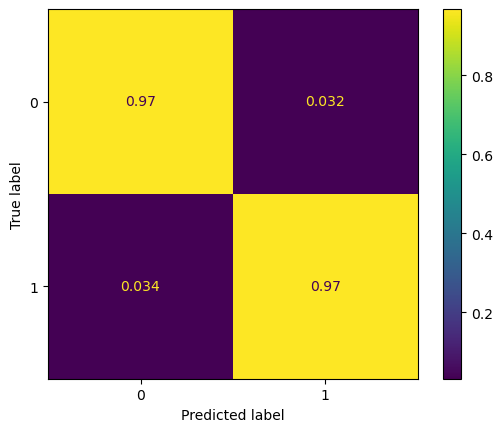

In [7]:
cm = confusion_matrix(y_test, y_pred, normalize='true')
# cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
# plt.savefig('T1ConfusionMatrix.png', bbox_inches='tight')
plt.close()

# (true negative, false positive)
# (false negative, true positive)
# want to have the least amount of false negatives

## Classification models for ensemble

In [6]:
# model = random forest
# clf1 = XGBClassifier(n_estimators=500, base_score=0.5, booster='gbtree', missing=0, verbosity=2)
clf1 = XGBClassifier(use_label_encoder=True, eval_metric="logloss", n_estimators=700, learning_rate=0.1, random_state=1)

# clf2 = GradientBoostingClassifier() # was above 0.9 but worse than xgboost

# models under 0.9
# clf1 = LogisticRegression(random_state=1)
# clf2 = RandomForestClassifier(n_estimators = 150, min_samples_split=5, random_state=1, bootstrap=False)
# clf3 = GaussianNB()
ada = AdaBoostClassifier(n_estimators=100, algorithm="SAMME", random_state=1)

## Grid search

In [9]:
rfc = RandomForestClassifier()
param_grid = {"n_estimators":[150,175], "min_samples_split":[5,10]}
grid_search = GridSearchCV(rfc, param_grid=param_grid, cv=2, scoring="recall")
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,),

{'min_samples_split': 5, 'n_estimators': 150}
0.9440559440559441


## Ensemble voting classifier and accuracy scores

In [ ]:
eclf = VotingClassifier(
    estimators = [('rf', model), ('xgb', clf1)],
    voting='hard')

for clf, label in zip([model, clf1, eclf], ['RandomForest', 'xgBoost', 'Ensemble']):
    scores = cross_val_score(clf, X, y.values.ravel(), scoring='accuracy', cv=5)
    print("Accuracy: %0.4f (+/- %0.4f) [%s]" % (scores.mean(), scores.std(), label))

In [20]:
eclf = VotingClassifier(
    estimators = [('rf', model), ('xgb', clf1)],
    voting='soft')

for clf, label in zip([model, clf1, eclf], ['RandomForest', 'xgBoost', 'Ensemble']):
    scores = cross_val_score(clf, X, y.values.ravel(), scoring='accuracy', cv=5)
    print("Accuracy: %0.4f (+/- %0.4f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.9690 (+/- 0.0035) [RandomForest]


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [09:30:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [09:30:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [09:30:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [09:30:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

Accuracy: 0.9730 (+/- 0.0038) [xgBoost]


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [09:31:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [09:31:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [09:31:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [09:31:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

Accuracy: 0.9744 (+/- 0.0028) [Ensemble]


## Plot

In [12]:
# names = ['Random Forest', 'xgBoost', 'Ensemble']
plt.rcParams.update({'font.size': fs})
names = ['Rand Forest', 'xgBoost', 'Ensemble']
floatScores = [0.0, 0.0, 0.0]
base = 95
fs = 50 # font size
width = 30
height = 30

for i in range(0,3):
    # print(f'{names[i]} Score: {(100*scores[i]):.2f}%')
    floatScores[i] = float(scores[i]*100) - 95

fig, ax = plt.subplots(figsize=(width, height))

# bar_labels = ['red', 'blue', 'yellow', 'orange']
bar_colors = ['tab:red', 'tab:blue', 'tab:orange', 'tab:red']

# ax.bar(names, floatScores, label=bar_labels, color=bar_colors, bottom=base)
ax.bar(names, floatScores, color=bar_colors, bottom=base)

ax.set_ylabel('Accuracy (%)', fontsize=fs, fontweight='bold')
ax.set_title('Accuracy of Various Classifiers', fontsize=fs, fontweight='bold')
# ax.legend(title='color')

plt.show()
# plt.savefig('T1AccuracyClassifiersHard.png', bbox_inches='tight')
plt.close()

NameError: name 'fs' is not defined

## Plot ensemble

In [27]:
model = eclf

model.fit(X_train, y_train)
print("Current model accuracy Score:", cross_val_score(model, X, y).mean())
y_pred = model.predict(X_test)

print("Recall Score:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [09:39:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to 

Current model accuracy Score: 0.9743538293798046
Recall Score: 0.9738955823293173
F1 Score: 0.9788092835519677


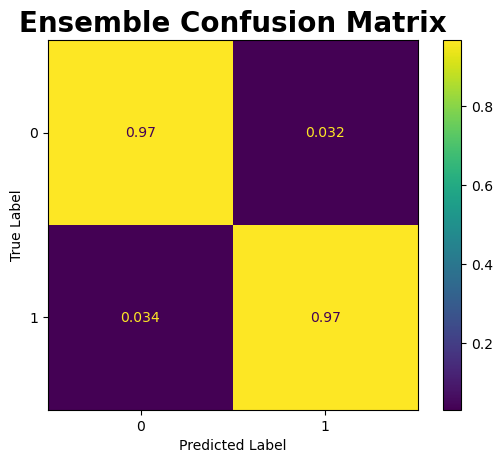

In [26]:
cm = confusion_matrix(y_test, y_pred, normalize='true')
# cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp.title()

# cm.plot(include_values=False, cmap='cividis')
disp.plot()
plt.title('Ensemble Confusion Matrix', fontweight='bold', fontsize=20)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
# plt.savefig('T1ConfusionMatrix.png', bbox_inches='tight')
plt.close()

# (true negative, false positive)
# (false negative, true positive)
# want to have the least amount of false negatives